<a href="https://colab.research.google.com/github/atuchiya/gf180-analog-tutorial/blob/main/fifty_nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fifty-Nifty Variations of Two-Transistor Circuits in GF180

Xschem schematic files :
https://github.com/atuchiya/gf180-analog-tutorial/tree/main/fifty_nifty

## 1. Introduction

This notebook investigates some circuits in Fifty-Nifty Variations on Two-Transistor Circuits in GlobalFoundries 180-nm CMOS ([gf180mcu](https://gf180mcu-pdk.readthedocs.io/en/latest/)). This document covers two design environments:
- ngspice in jupyter-notebook (this notebook)
- Xschem + ngspice in [IIC-OSIC-TOOLS tuned for Chipathon 2025](https://github.com/sscs-ose/sscs-chipathon-2025)

Reference: H. Pretl and M. Eberlein, "Fifty-Nifty Variations on Two-Transistor Circuits," IEEE Solid-State Circuits Magazine, vol. 13, No. 3, pp.38-46, 2021, doi:10.1109/MSSC.2021.3088968

### 1.1 Notation Rules

In thsi document, basic notation rule is as follows
- Upper case means large signal (including nonlinear effect). i.e. $V$, $I$, $R$, etc.
- Lower case means small signal (linear approximation), i.e. $v$, $i$, $r$, etc.
- Voltage $V$ with subscription, for example $V_{\mathrm{AB}}$, means voltage difference from node B to node A. Thus, $V_{\mathrm{AB}}=-V_{\mathrm{BA}}$.
- Some special variables:
  - $V_{\mathrm{DD}}$ : the supply voltage
  - $V_{\mathrm{SS}}$ : the common voltage (usually, equal to ground voltage (0 V))






##2. Installing ngspice and PDK

Simulation setup is adopted from [IEEE SSCS OSE Chipathon template](https://github.com/sscs-ose/sscs-ose-chipathon.github.io/blob/main/template_notebook_to_follow.ipynb)

In [145]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

ngspice_version = 'latest' #@param {type:"string"}
gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
import urllib.request

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     ngspice={ngspice_version}

ngspice_models_dir = pathlib.Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

Empty environment created at prefix: /content/conda-env

Pinned packages:

  - python==3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - ngspice


  Package                      Version  Build            Channel         Size
───────────────────────────────────────────────────────────────────────────────
  Install:
───────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                  0.1  main             main          Cached
  + _openmp_mutex                  5.1  1_gnu            main          Cached
  + libgcc-ng                   11.2.0  h1234567_1       main          Cached
  + libgomp                     11.2.0  h1234567_1       main          Cached
  + libstdcxx-ng                11.2.0  h1234567_1       main          Cached
  + ngspice        39.3_552_g902a62d2f  20240223_100318  litex-hub     Cached

  Summary:

  Install: 6 packages

  Total download: 0 B

────────────────────────────────────────────────────

In [146]:
%%writefile .spiceinit
set ngbehavior=hs

Overwriting .spiceinit


In [147]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##3. Logic Circuits

### #1 Digital Inverter

One of the basic logic circuit is inverter (NOT gate). When the input is low, the output is high. When the input is high, the output is low.

First, check Input-Output curve by DC analysis.

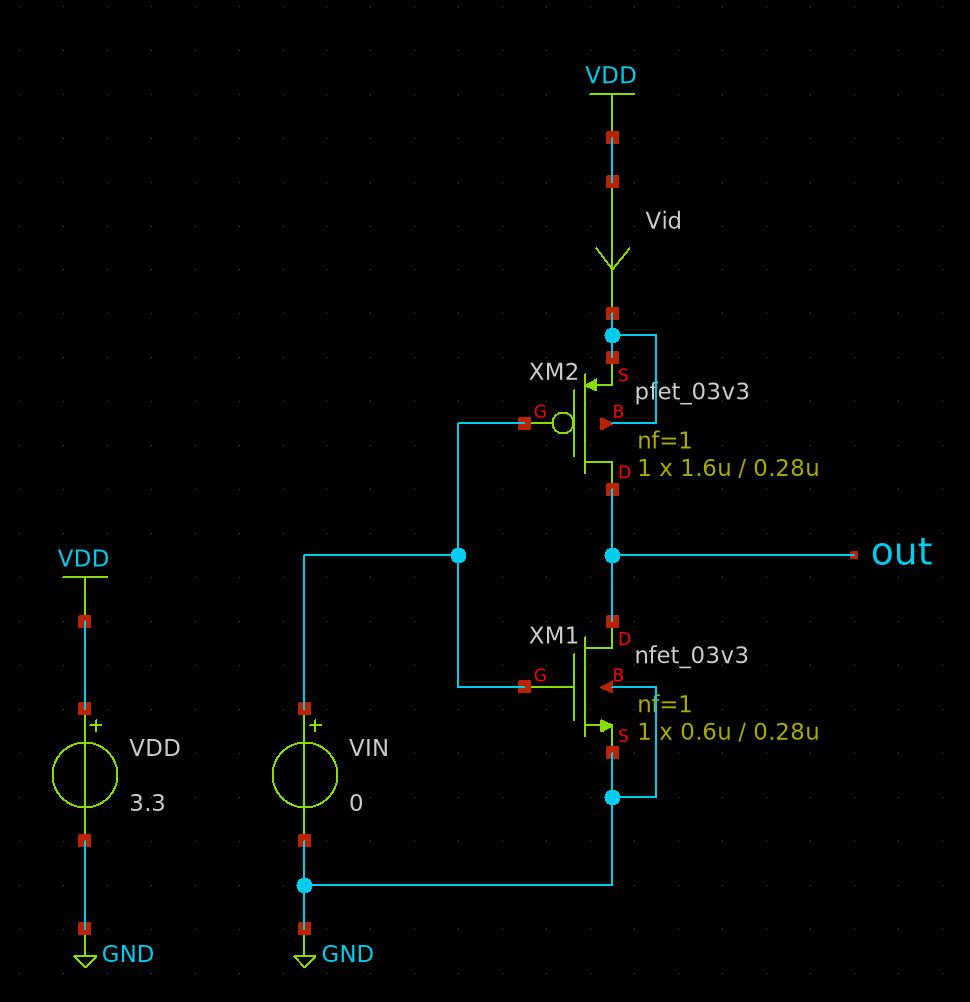

In [148]:
%%writefile 01_inv_dc.spice
* INV

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 out in GND GND nfet_03v3 L=0.28u W=0.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in vdd vdd pfet_03v3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VIN in GND 0

.measure dc vlt when v(out)=1.65

.option savecurrent
.control
save all
dc VIN 0 3.3 0.01
wrdata 01_inv_dc.txt V(out) i(Vdd)
.endc
.end

Overwriting 01_inv_dc.spice


This netlsit includes `.measure` statement.
```
.measure dc vlt when v(out)=1.65
```
This statement means "find VIN value when v(out)=1.65". 1.65 V is $V_{\mathrm{DD}}/2$. This input voltage is the voltage where the output voltage flips. It is called "logic threshold voltage". The logic threshold voltage is determined by the ratio of pMOS channel width and nMOS channel width. In many processes, pMOS should be larger than nMOS.

In [149]:
!ngspice -b 01_inv_dc.spice


Note: Compatibility modes selected: hs



Circuit: * inv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331

  Measurements for DC Analysis

vlt                 =   1.61261e+00

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


  Measurements for DC Analysis

vlt                 =   1.61261e+00


Total analysis time (seconds) = 0.006784

Total CPU time (seconds) = 0.069 

Total DRAM available = 12977.953 MB.
DRAM currently available = 8790.891 MB.
Maximum ngspice program size =   18.629 MB.
Current ngspice program size =   13.543 MB.

Shared ngspice pages =    7.098 MB.
Text (code) pages =    5.102 MB.
Stack = 0 bytes.
Library pages =    7.418 MB.



The I-O curve and the current flow are shown.

/tmp/ipython-input-150-3794323346.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("01_inv_dc.txt", delim_whitespace=True, header=None)


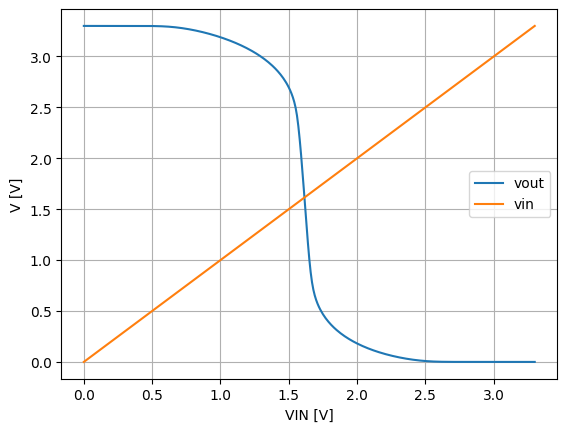

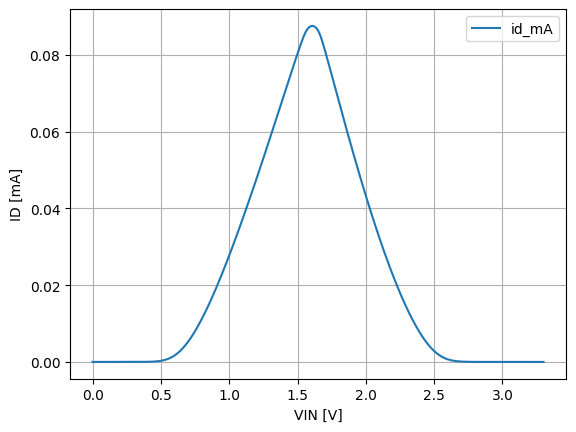

In [150]:
df = pd.read_csv("01_inv_dc.txt", delim_whitespace=True, header=None)
df.columns = ["vin", "vout", "vin_", "id"]
df['id_mA'] = df['id'] * -1000

plt.plot(df['vin'], df['vout'], label='vout')
plt.plot(df['vin'], df['vin'], label='vin')
plt.xlabel("VIN [V]")
plt.ylabel("V [V]")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['vin'], df['id_mA'], label='id_mA')
plt.xlabel("VIN [V]")
plt.ylabel("ID [mA]")
plt.legend()
plt.grid(True)
plt.show()

Then, let's check transient waveform. The performance measures in transient analysis are:
- signal propagation delay : time from Vin=VDD/2 to Vout=VDD/2 (rising edge and falling edge)
- rise time : time from Vout=VDD\*0.2 to Vout=VDD\*0.8
- fall time : time from Vout=VDD\*0.8 to Vout=VDD\*0.2

These are obtained by `.measure` statements.

In [151]:
%%writefile 01_inv_tran.spice
* INV

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 out in GND GND nfet_03v3 L=0.28u W=0.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in vdd vdd pfet_03v3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VIN in GND pwl 0 0 100n 0 120n 3.3 200n 3.3 220n 0
Cload out GND 100f

.measure tran tdr trig V(in) val=1.65 rise=1 targ V(out) val=1.65 fall=1
.measure tran tdf trig V(in) val=1.65 fall=1 targ V(out) val=1.65 rise=1
.measure tran tr trig V(out) val=0.66 rise=1 targ V(out) val=2.64 rise=1
.measure tran tf trig V(out) val=2.64 fall=1 targ V(out) val=0.66 fall=1

.option savecurrent
.control
save all
tran 1n 300n
wrdata 01_inv_tran.txt V(in) V(out) i(Vdd)
.endc
.end

Overwriting 01_inv_tran.spice


In [152]:
!ngspice -b 01_inv_tran.spice


Note: Compatibility modes selected: hs



Circuit: * inv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
out                                        3.3
in                                           0
vdd                                        3.3
vin#branch                                   0
vdd#branch                        -3.80512e-12


No. of Data Rows : 322

  Measurements for Transient Analysis

tdr                 =  1.792869e-09 targ=  1.117929e-07 trig=  1.100000e-07
tdf                 =  2.252928e-09 targ=  2.122529e-07 trig=  2.100000e-07
tr                  =  2.772004e-09 targ=  2.134267e-07 trig=  2.106547e-07
tf                  =  2.994976e-09 targ=  1.130092e-07 trig=  1.100142e-07

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


  Measurements for Transient Analysis

tdr                 =  1.792869e

/tmp/ipython-input-153-2609420847.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("01_inv_tran.txt", delim_whitespace=True, header=None)


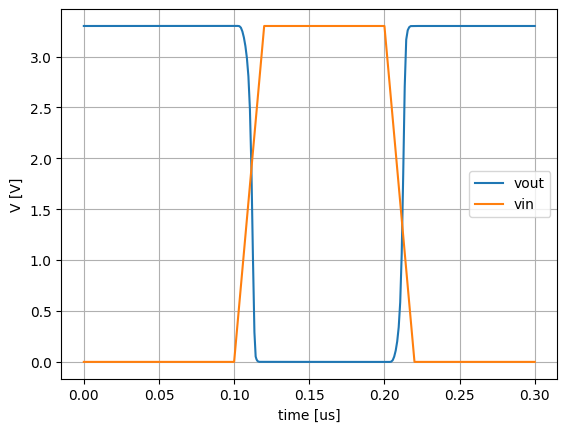

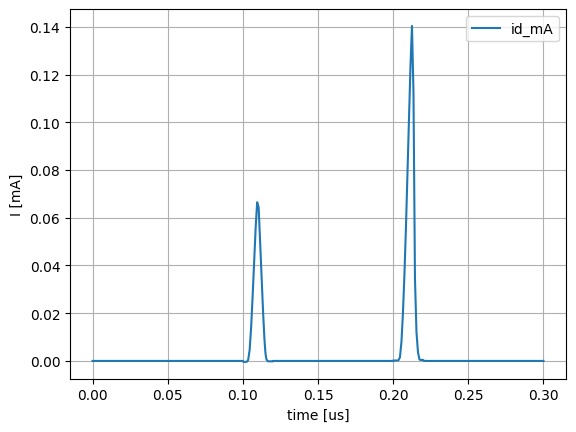

In [153]:
df = pd.read_csv("01_inv_tran.txt", delim_whitespace=True, header=None)
df.columns = ["time", "vin", "time_", "vout", "time__", "id"]
df['id_mA'] = df['id'] * -1000
df['t_us'] = df['time'] * 1e6

plt.plot(df['t_us'], df['vout'], label='vout')
plt.plot(df['t_us'], df['vin'], label='vin')
plt.xlabel("time [us]")
plt.ylabel("V [V]")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['t_us'], df['id_mA'], label='id_mA')
plt.xlabel("time [us]")
plt.ylabel("I [mA]")
plt.legend()
plt.grid(True)
plt.show()

This circuit can also work as an analog amplifier (push-pull amplifier).

In [ ]:
%%writefile 01_inv_ac.spice
* INV

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 out in GND GND nfet_03v3 L=0.28u W=0.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in vdd vdd pfet_03v3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VIN in GND DC 1.65 AC 1
Cload out GND 100f

.option savecurrent
.control
save all
ac dec 20 1e6 1e10
wrdata 01_inv_ac.txt V(out)
.endc
.end

Writing 01_inv_ac.spice


In [154]:
!ngspice -b 01_inv_ac.spice


Note: Compatibility modes selected: hs



Circuit: * inv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 81
Note: Simulation executed from .control section 


/tmp/ipython-input-155-1345131209.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("01_inv_ac.txt", delim_whitespace=True, header=None)


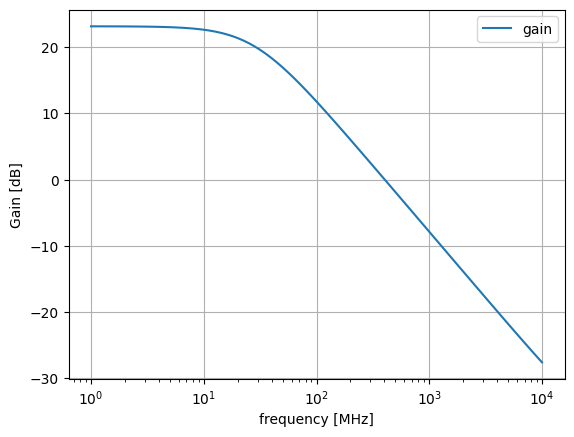

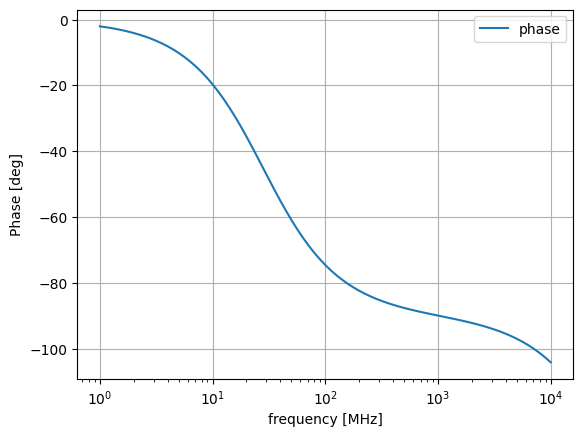

In [155]:
df = pd.read_csv("01_inv_ac.txt", delim_whitespace=True, header=None)
df.columns = ["freq", "real", "img"]
z = df['real'] + 1j * df['img']
df["gain_dB"] = 20 * np.log10(np.abs(z))
df["phase_deg"] = np.degrees(np.angle(z)) - 180
df['freq_MHz'] = df['freq'] / 1e6

plt.plot(df['freq_MHz'], df['gain_dB'], label="gain")
plt.xlabel("frequency [MHz]")
plt.ylabel("Gain [dB]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['freq_MHz'], df['phase_deg'], label="phase")
plt.xlabel("frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


##4. Basic Circuits

### #7 Basic Current Mirror

Current mirror is an essential block for analog circuits. Current mirror copies (multiplies) the reference current. First, check if the output current follows the input (reference) current.

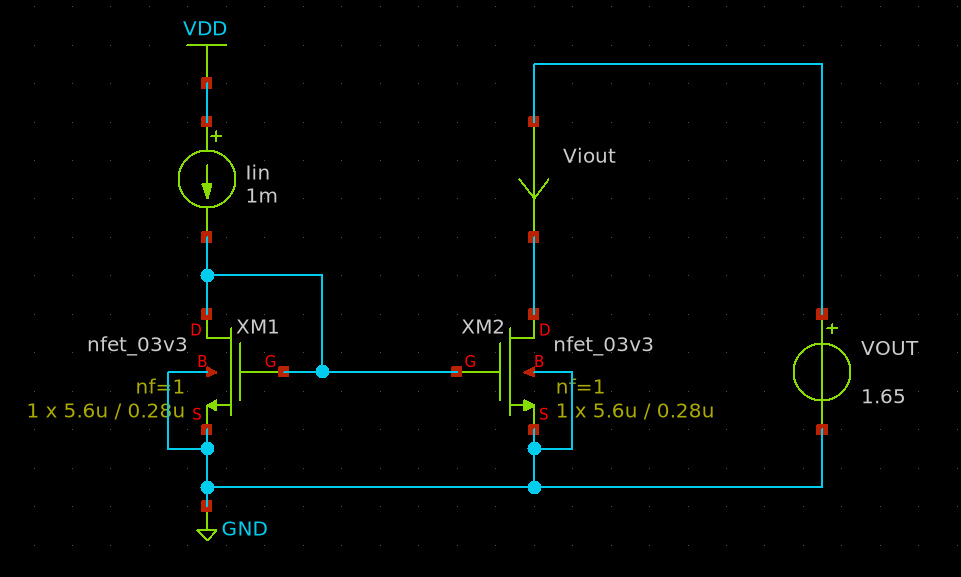

In [156]:
%%writefile 07_cm_dc.spice
* Current Mirror

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 in in GND GND nfet_03v3 L=0.28u W=5.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in GND GND nfet_03v3 L=0.28u W=5.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
IIN vdd in 1m
VOUT out GND 1.65

.option savecurrent
.control
save all
dc IIN 0 1m 0.01m
wrdata 07_cm_dc.txt i(VOUT)
.endc
.end

Overwriting 07_cm_dc.spice


In [157]:
!ngspice -b 07_cm_dc.spice


Note: Compatibility modes selected: hs



Circuit: * current mirror

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 101
Note: Simulation executed from .control section 


/tmp/ipython-input-158-1758319962.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("07_cm_dc.txt", delim_whitespace=True, header=None)


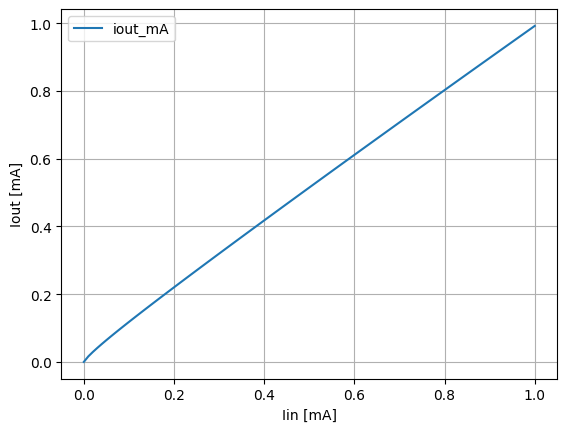

In [158]:
df = pd.read_csv("07_cm_dc.txt", delim_whitespace=True, header=None)
df.columns = ["iin", "iout"]
df['iin_mA'] = df['iin'] * 1000
df['iout_mA'] = -df['iout'] * 1000

plt.plot(df['iin_mA'], df['iout_mA'], label='iout_mA')
plt.xlabel('Iin [mA]')
plt.ylabel('Iout [mA]')
plt.legend()
plt.grid(True)
plt.show()

The expected behavior of current mirror is to act as an ideal current source. So, idealy, the output current does not depend on the output voltage.

In [159]:
%%writefile 07_cm_dc2.spice
* Current Mirror

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 in in GND GND nfet_03v3 L=0.28u W=5.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in GND GND nfet_03v3 L=0.28u W=5.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
IIN vdd in 1m
VOUT out GND 1.65

.option savecurrent
.control
save all
dc VOUT 0 3.3 0.01
wrdata 07_cm_dc2.txt i(VOUT)
.endc
.end

Overwriting 07_cm_dc2.spice


In [160]:
!ngspice -b 07_cm_dc2.spice


Note: Compatibility modes selected: hs



Circuit: * current mirror

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


/tmp/ipython-input-161-2529779450.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("07_cm_dc2.txt", delim_whitespace=True, header=None)


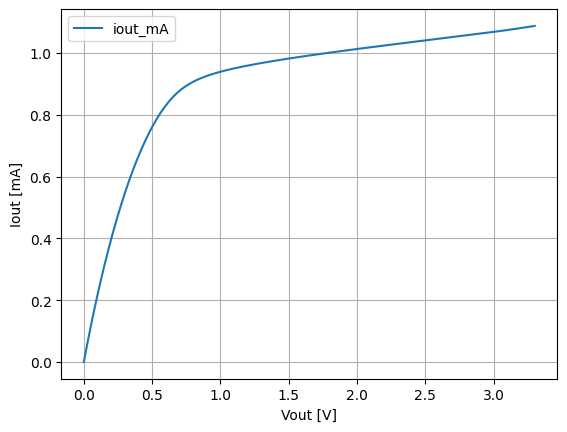

In [161]:
df = pd.read_csv("07_cm_dc2.txt", delim_whitespace=True, header=None)
df.columns = ["vout", "iout"]
df['iout_mA'] = -df['iout'] * 1000

plt.plot(df['vout'], df['iout_mA'], label='iout_mA')
plt.xlabel('Vout [V]')
plt.ylabel('Iout [mA]')
plt.legend()
plt.grid(True)
plt.show()

When the output voltage is low, the nMOSFET is in the linear region. So the MOSFET is a resistor, not a current source. When the output voltage is high enough, nMOSFET works in saturation region. But as you see, the output current depends on the output voltage. This means, the output resistance is low.

To increase the output resistance $r_{\mathrm{ds}}$, increasing the channel length $L$ is one way. Or, advanced topologies such as cascode current mirror, Wilson current mirror, Widlar current mirror and so on, can realise much higher output resistance.

### #8 Differential Pair

Differential pair has two inputs and two outputs. It amplifies difference between two inputs. To realize differential signal, VCVS (Voltage-Controlled Voltage Source) `E` is used.

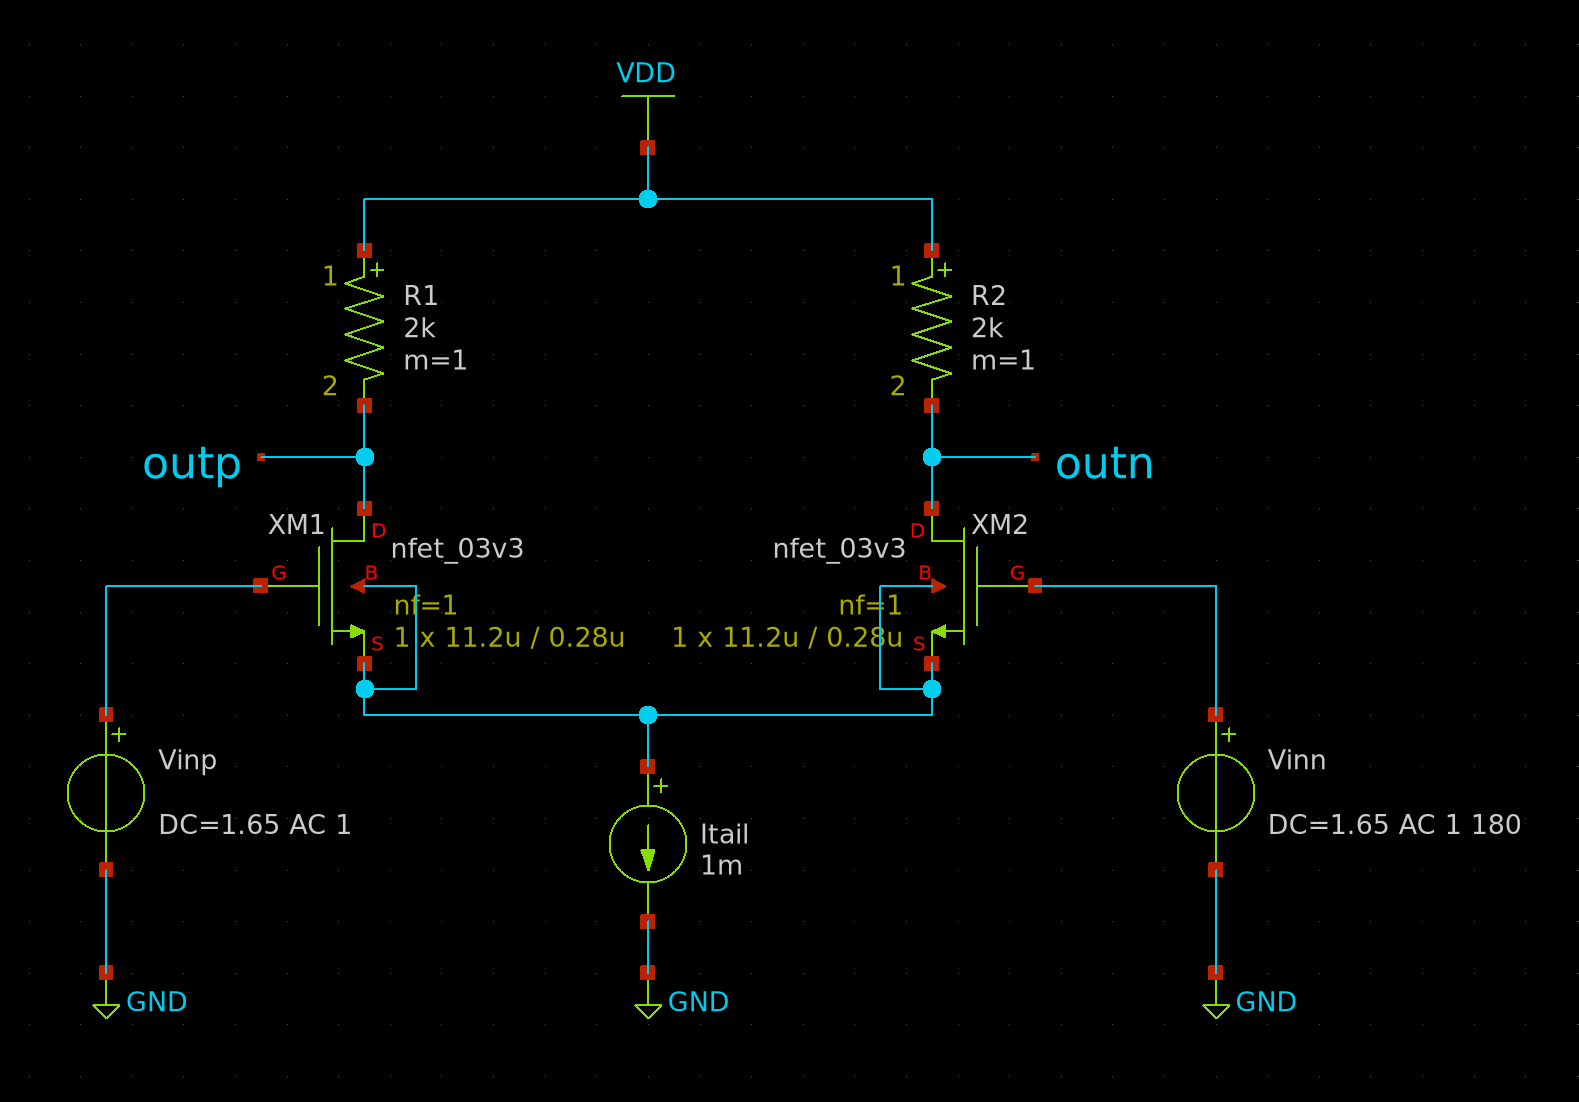

In [162]:
%%writefile 08_diff_dc.spice
* Diff pair

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 outp inp S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 outn inn S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
Rp vdd outp 2k
Rn vdd outn 2k
Itail S GND 1m
Vcommon com GND 1.65
Vinp inp com 0
Einn inn com inp com -1

.option savecurrent
.control
save all
dc vinp -1.65 1.65 0.01
wrdata 08_diff_dc.txt V(inp) V(inn) V(outp) V(outn)
.endc
.end

Overwriting 08_diff_dc.spice


In [163]:
!ngspice -b 08_diff_dc.spice


Note: Compatibility modes selected: hs



Circuit: * diff pair

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


/tmp/ipython-input-164-2750384130.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("08_diff_dc.txt", delim_whitespace=True, header=None)


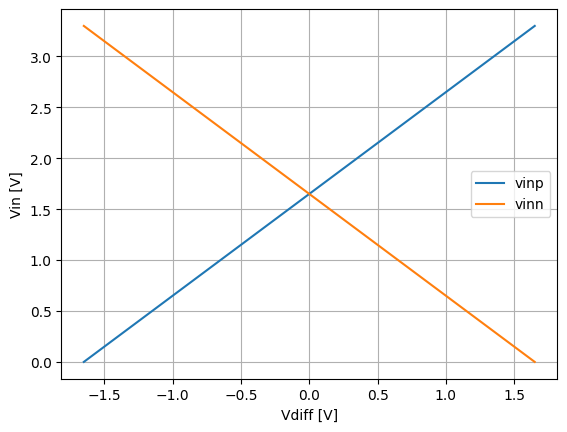

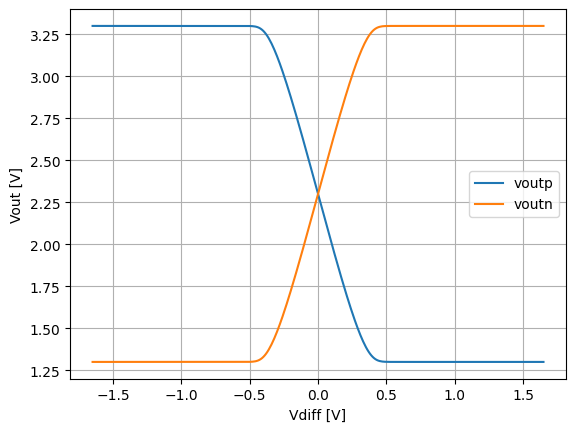

In [164]:
df = pd.read_csv("08_diff_dc.txt", delim_whitespace=True, header=None)
df.columns = ["vdiff", "vinp", "vdiff_", "vinn", "vdiff__", "voutp", "vdiff___", "voutn"]

plt.plot(df['vdiff'], df['vinp'], label='vinp')
plt.plot(df['vdiff'], df['vinn'], label='vinn')
plt.xlabel('Vdiff [V]')
plt.ylabel('Vin [V]')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['vdiff'], df['voutp'], label='voutp')
plt.plot(df['vdiff'], df['voutn'], label='voutn')
plt.xlabel('Vdiff [V]')
plt.ylabel('Vout [V]')
plt.legend()
plt.grid(True)
plt.show()

An important feature of the differential pair is common-mode rejection. If the voltage of two inputs changes to the same direction, the output voltage does not change. Now the netlist to input common-mode voltage is as follows:

In [165]:
%%writefile 08_diff_dc2.spice
* Diff pair

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 outp inp S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 outn inn S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
Rp vdd outp 2k
Rn vdd outn 2k
Itail S GND 1m
Vcommon com GND 1.65
Vinp inp com 0
Einn inn com inp com 1

.option savecurrent
.control
save all
dc vinp -1.65 1.65 0.01
wrdata 08_diff_dc2.txt V(inp) V(inn) V(outp) V(outn)
.endc
.end

Overwriting 08_diff_dc2.spice


In [166]:
!ngspice -b 08_diff_dc2.spice


Note: Compatibility modes selected: hs



Circuit: * diff pair

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


/tmp/ipython-input-167-3645436395.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("08_diff_dc2.txt", delim_whitespace=True, header=None)


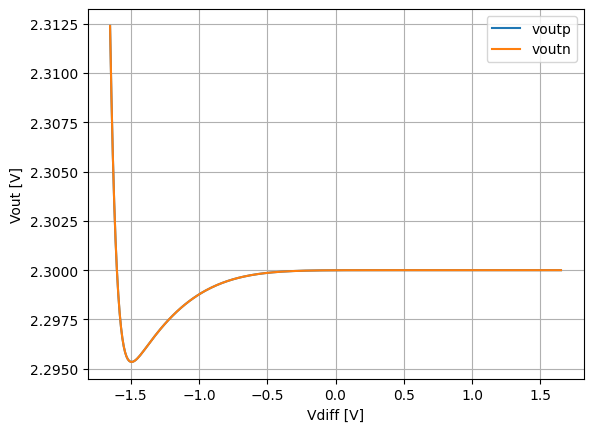

In [167]:
df = pd.read_csv("08_diff_dc2.txt", delim_whitespace=True, header=None)
df.columns = ["vdiff", "vinp", "vdiff_", "vinn", "vdiff__", "voutp", "vdiff___", "voutn"]

plt.plot(df['vdiff'], df['voutp'], label='voutp')
plt.plot(df['vdiff'], df['voutn'], label='voutn')
plt.xlabel('Vdiff [V]')
plt.ylabel('Vout [V]')
plt.legend()
plt.grid(True)
plt.show()

The output voltage is almost constant.

--

For AC analysis, set phase to the voltage source `vinn`. (No need to use VCVS)

In [168]:
%%writefile 08_diff_ac.spice
* Diff pair

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 outp inp S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 outn inn S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
Rp vdd outp 2k
Rn vdd outn 2k
Itail S GND 1m
Vinp inp GND 1.65 AC 1
Vinn inn GND 1.65 AC 1 180
Cloadp outp GND 100f
Cloadn outn GND 100f

.option savecurrent
.control
save all
ac dec 20 1e6 1e10
wrdata 08_diff_ac.txt V(outp)
.endc
.end

Overwriting 08_diff_ac.spice


In [169]:
!ngspice -b 08_diff_ac.spice


Note: Compatibility modes selected: hs



Circuit: * diff pair

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 81
Note: Simulation executed from .control section 


/tmp/ipython-input-170-3553075110.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("08_diff_ac.txt", delim_whitespace=True, header=None)


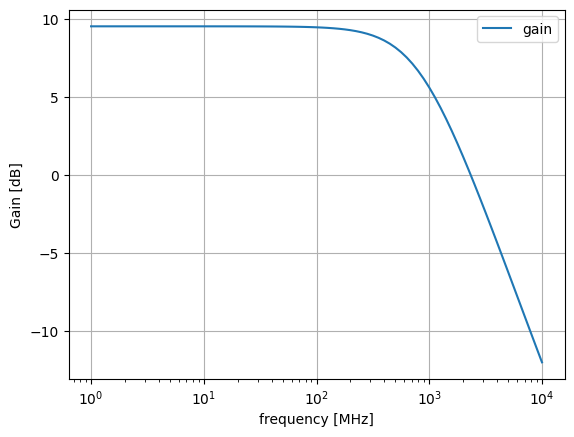

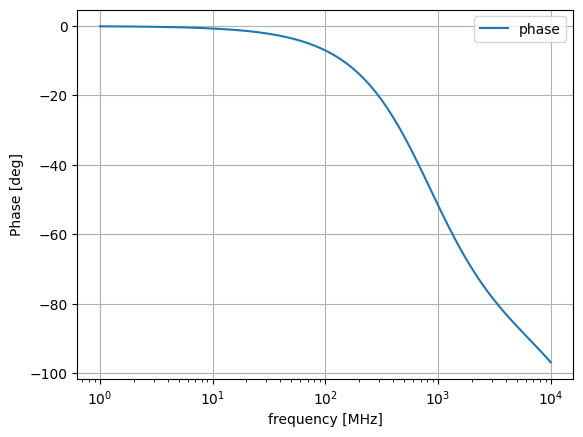

In [170]:
df = pd.read_csv("08_diff_ac.txt", delim_whitespace=True, header=None)
df.columns = ["freq", "real", "img"]
z = df['real'] + 1j * df['img']
df["gain_dB"] = 20 * np.log10(np.abs(z))
df["phase_deg"] = np.degrees(np.angle(z)) - 180
df['freq_MHz'] = df['freq'] / 1e6

plt.plot(df['freq_MHz'], df['gain_dB'], label="gain")
plt.xlabel("frequency [MHz]")
plt.ylabel("Gain [dB]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['freq_MHz'], df['phase_deg'], label="phase")
plt.xlabel("frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

Also, check common-mode response.

In [171]:
%%writefile 08_diff_ac2.spice
* Diff pair

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 outp inp S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 outn inn S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
Rp vdd outp 2k
Rn vdd outn 2k
Itail S GND 1m
Vinp inp GND 1.65 AC 1
Vinn inn GND 1.65 AC 1
Cloadp outp GND 100f
Cloadn outn GND 100f

.option savecurrent
.control
save all
ac dec 20 1e6 1e10
wrdata 08_diff_ac2.txt V(outp)
.endc
.end

Overwriting 08_diff_ac2.spice


In [172]:
!ngspice -b 08_diff_ac2.spice


Note: Compatibility modes selected: hs



Circuit: * diff pair

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 81
Note: Simulation executed from .control section 


/tmp/ipython-input-173-103332438.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("08_diff_ac2.txt", delim_whitespace=True, header=None)


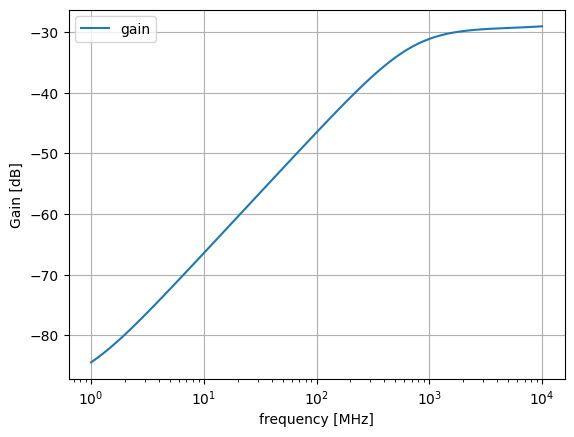

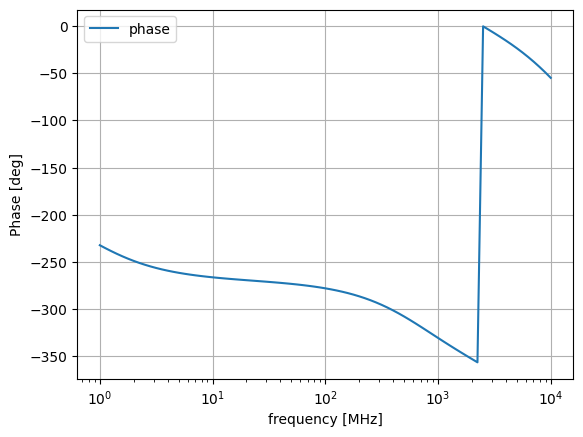

In [173]:
df = pd.read_csv("08_diff_ac2.txt", delim_whitespace=True, header=None)
df.columns = ["freq", "real", "img"]
z = df['real'] + 1j * df['img']
df["gain_dB"] = 20 * np.log10(np.abs(z))
df["phase_deg"] = np.degrees(np.angle(z)) - 180
df['freq_MHz'] = df['freq'] / 1e6

plt.plot(df['freq_MHz'], df['gain_dB'], label="gain")
plt.xlabel("frequency [MHz]")
plt.ylabel("Gain [dB]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['freq_MHz'], df['phase_deg'], label="phase")
plt.xlabel("frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

At low frequency, the gain is almost zero. As the frequency increases, the common-mode gain increases because the parasitic capacitance between the gate and the drain passes the input signal to the output node.

Now, let's see transient waveforms.

In [213]:
%%writefile 08_diff_tran.spice
* Diff pair

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

.param voff = 1.65 vamp = 0.1 fsig = 10e6 phasen = 180

XM1 outp inp S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 outn inn S GND nfet_03v3 L=0.28u W=11.2u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
Rp vdd outp 2k
Rn vdd outn 2k
Itail S GND 1m
Vinp inp GND sin voff vamp fsig 0 0 0
Vinn inn GND sin voff vamp fsig 0 0 phasen
Cloadp outp GND 100f
Cloadn outn GND 100f

.option savecurrent
.control
save all
tran 1n 500n
wrdata 08_diff_tran.txt V(inp) V(inn) V(outp) V(outn)
.endc
.end

Overwriting 08_diff_tran.spice


In [214]:
!ngspice -b 08_diff_tran.spice


Note: Compatibility modes selected: hs



Circuit: * diff pair

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
outp                                       2.3
inp                                       1.65
s                                     0.509015
outn                                       2.3
inn                                       1.65
vdd                                        3.3
vinn#branch                                  0
vinp#branch                                  0
vdd#branch                              -0.001


No. of Data Rows : 508
Note: Simulation executed from .control section 


/tmp/ipython-input-215-1288995725.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("08_diff_tran.txt", delim_whitespace=True, header=None)


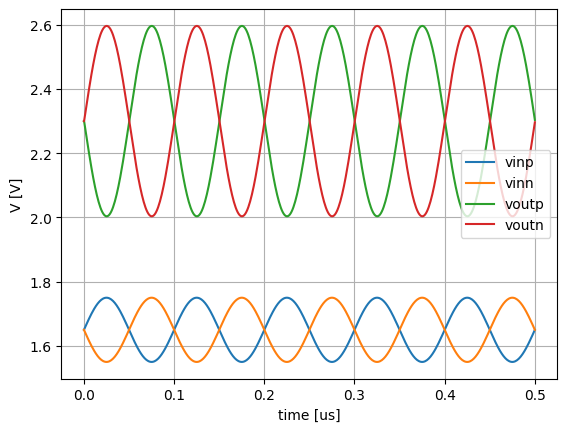

In [215]:
df = pd.read_csv("08_diff_tran.txt", delim_whitespace=True, header=None)
df.columns = ["time", "vinp", "time_", "vinn", "time__", "voutp", "time___", "voutn"]
df['t_us'] = df['time'] * 1e6

plt.plot(df['t_us'], df['vinp'], label='vinp')
plt.plot(df['t_us'], df['vinn'], label='vinn')
plt.plot(df['t_us'], df['voutp'], label='voutp')
plt.plot(df['t_us'], df['voutn'], label='voutn')
plt.xlabel("time [us]")
plt.ylabel("V [V]")
plt.legend()
plt.grid(True)
plt.show()

Try various input waveforms.

- small differential input
```
.param voff = 1.65 vamp = 0.1 fsig = 10e6 phasen = 180
```
- large differential input
```
.param voff = 1.65 vamp = 1 fsig = 10e6 phasen = 180
```
- common-mode input
```
.param voff = 1.65 vamp = 0.1 fsig = 10e6 phasen = 0
```
- single input
```
Vinp inp GND sin voff vamp fsig 0 0 0
Vinn inn GND voff
```

